C 98.48857801796105 L 370.1351104664349 U 320.1562118716424 Upr 161.24515496597098
RUC 146.45844226151888 RCL -606.587452971646 RC [0.0, 89.15345255585389]
98.48857801796105 320.1562118716424 370.1351104664349 161.24515496597098 294.27877939124323
1.548157698977968 14.470294100065889 Upr o -82.87498365109819 66.03751102542182 -80.21759296819272 90.0 2.657390682905481
0.0
To 2.657390682905481


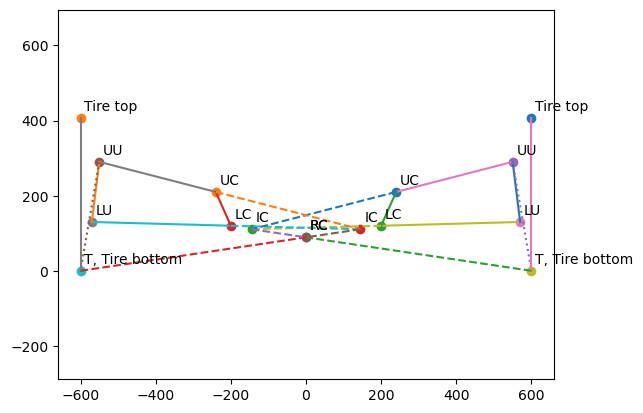

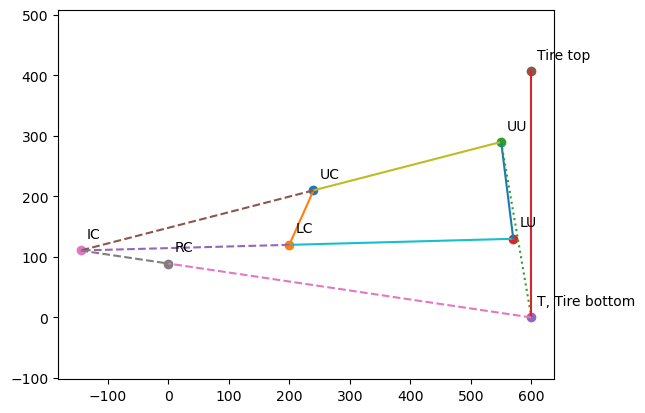

[0.0, 89.15345255585389]


In [29]:
# === IMPORTS AND SETUP ===
#%matplotlib qt
#%matplotlib qt
import numpy as np
from scipy.optimize import fsolve
from numpy import sin, cos, pi, arctan
import matplotlib.pyplot as plt
from matplotlib import animation

# === VEHICLE CONFIGURATION ===
# Coordinate system: X+ front, Y+ driver side, Z+ up (roof)
# Chassis and upright hardpoints in mm (Y/Z plane), measured at mid-travel

# Mode definitions:
# mode 0 = fixed track width
# mode 1 = roll center fixed during roll
# mode 2 = roll center free to move
mode = 1
front= True
#front= False
# === SAMPLING FOR MOTION ANALYSIS ===
steps = 61                  # Number of evaluation points
plotrange = 60              # Range of vertical motion (mm)
stepsize = plotrange / (steps - 1)  # mm per step
angle = 3 / 180 * pi     # Total roll angle in radians
stepang = angle / (steps - 1)  # radians per step


#calculator works by using these hardpoints in calculations, only change these to change the suspension then click run all
if front != True:
    # === HARDPOINTS (Y,Z coordinates) ===
    UCy = 250
    UCz = 210
    UC = [UCy, UCz]  # Upper chassis points
    
    LCy = 180
    LCz = 120
    LC = [LCy, LCz]  # Lower chassis points
    
    UUy = 540
    UUz = 300
    UU = [UUy, UUz]  # Upper upright points
    
    LUy = 550
    LUz = 130
    LU = [LUy, LUz]  # Lower upright points
else:
    UCy = 240 
    UCz = 210
    UC = [UCy, UCz]  # Upper chassis points
    
    LCy = 200
    LCz = 120
    LC = [LCy, LCz]  # Lower chassis points
    
    UUy = 550
    UUz = 290
    UU = [UUy, UUz]  # Upper upright points
    
    LUy = 570
    LUz = 130
    LU = [LUy, LUz]  # Lower upright points

# === CONTROL ARM LENGTHS ===
C = ((UCy - LCy)**2 + (UCz - LCz)**2)**0.5  # Chassis vertical span
L = ((LUy - LCy)**2 + (LUz - LCz)**2)**0.5  # Lower control arm
U = ((UUy - UCy)**2 + (UUz - UCz)**2)**0.5  # Upper control arm
Upr = ((UUy - LUy)**2 + (UUz - LUz)**2)**0.5  # Upright
Ctop = 2 * UCy  # Reference for roll simulation
Cbot = 2 * LCy

print("C", C, "L", L, "U", U, "Upr", Upr)

# === TIRE AND TRACK MEASUREMENTS ===
TD = 406.4         # Tire diameter in mm (16 inches)
TR = TD / 2        # Tire radius
Track = 600        # Half track width (1 side of the car)
TCz = 220.6 - 17.4  # Tire center Z coordinate
Tz = TCz - TR      # Tire bottom contact patch Z coordinate
TUU = ((Track - UUy)**2 + (Tz - UUz)**2)**0.5  # Length from upper upright to tire patch
TUC = ((Track - UCy)**2 + (Tz - UCz)**2)**0.5  # Length from upper chassis to tire patch
T = [Track, Tz]    # Tire contact patch location

# === ANGLE DEFINITIONS ===
LLCo = arctan((LUz - LCz) / (LUy - LCy))        # Lower control arm
UUCo = arctan((UUz - UCz) / (UUy - UCy))        # Upper control arm
UprUUo = arctan((LUz - UUz) / (LUy - UUy))      # Upright
CLCo = arctan((UCz - LCz) / (UCy - LCy))        # Chassis reference
TUUo = arctan((Tz - UUz) / (Track - UUy))       # Tire to upper upright
TUCo = arctan((Tz - UCz) / (Track - UCy))       # Tire to upper chassis

To = TUUo - UprUUo         # Relative upright-to-tire angle
T90 = pi/2 - TUUo          # Perpendicular direction to tire contact
TDo = TUUo + T90           # Tire top offset direction
TDD = [T[0] + TD * cos(TDo), T[1] + TD * sin(TDo)]  # Tire top coordinates

# === INSTANT CENTER ANALYSIS ===
def ICloop(guess):
    ICL, ICU = guess
    loop = np.zeros(2)
    loop[0] = LC[0] - ICL * cos(LLCo) + ICU * cos(UUCo) - UC[0]
    loop[1] = LC[1] - ICL * sin(LLCo) + ICU * sin(UUCo) - UC[1]
    return loop

guess = [0, 0]
(ICL, ICU) = fsolve(ICloop, guess)  # Solve for IC link distances
IC = [LC[0] - ICL * cos(LLCo), LC[1] - ICL * sin(LLCo)]  # IC coordinates

# === ROLL CENTER CALCULATION ===
TRo = arctan((Tz - IC[1]) / (Track - IC[0]))  # Angle from IC to tire patch

def RCloop(guess):
    RCL, RCU, XXX = guess
    loop = np.zeros(3)
    loop[0] = T[0] + RCL * cos(TRo) - RCU * cos(TRo) - IC[0]
    loop[1] = T[1] + RCL * sin(TRo) - RCU * sin(TRo) - IC[1]
    loop[2] = T[0] + RCL * cos(TRo)  # Symmetry constraint (forces geometry to resolve in one plane)
    return loop

guess = [0, 0, 0]
(RCL, RCU, XXX) = fsolve(RCloop, guess)
RC = [T[0] + RCL * cos(TRo), T[1] + RCL * sin(TRo)]  # Roll center coordinates

print("RUC", RCU, "RCL", RCL, "RC", RC)

# === SUMMARY OF GEOMETRY ===
print(C, U, L, Upr, TUU)
print(
    LLCo * 360 / (2 * pi), UUCo * 360 / (2 * pi),
    "Upr o", UprUUo * 360 / (2 * pi),
    CLCo * 360 / (2 * pi), TUUo * 360 / (2 * pi),
    TDo * 360 / (2 * pi), To * 360 / (2 * pi)
)
print(Tz)  # Z-height of tire bottom (should be ~0)
print("To", To*180/pi)
# === VISUALIZATION: SYMMETRIC VIEW ===
fig, ax = plt.subplots()
for name, point in zip(['UC','LC','UU','LU','T, Tire bottom', 'Tire top',"IC","RC"], [UC, LC, UU, LU, T, TDD, IC, RC]):
    ax.text(point[0]+10, point[1]+20, name)
    ax.plot(point[0], point[1], "o")
    ax.text(-point[0]+10, point[1]+20, name)   # Mirror image (left side)
    ax.plot(-point[0], point[1], "o")

# Draw lines for all components
for start, R, O, style in zip(
    [UC, LC, UU, LC, UU, T, LC, UC, T, IC],   # Starting points
    [U, L, Upr, C, TUU, TD, ICL, ICU, RCL, RCU],  # Lengths
    [UUCo, LLCo, UprUUo, CLCo, TUUo, TDo, LLCo + pi, UUCo + pi, TRo, TRo],  # Angles
    ('-', '-', '-', '-', ':', '-', '--', '--', '--', '--')  # Line styles
):
    ax.plot([start[0], start[0] + R * cos(O)], [start[1], start[1] + R * sin(O)], style)
    ax.plot([-start[0], -start[0] - R * cos(O)], [start[1], start[1] + R * sin(O)], style)  # Symmetric side

plt.axis('equal')
plt.show()

# === VISUALIZATION: DRIVER-SIDE ONLY ===
fig, ax = plt.subplots()
for name, point in zip(['UC','LC','UU','LU','T, Tire bottom', 'Tire top',"IC","RC"], [UC, LC, UU, LU, T, TDD, IC, RC]):
    ax.text(point[0]+10, point[1]+20, name)
    ax.plot(point[0], point[1], "o")

for start, R, O, style in zip(
    [UC, LC, UU, LC, UU, T, LC, UC, T, IC],
    [U, L, Upr, C, TUU, TD, ICL, ICU, RCL, RCU],
    [UUCo, LLCo, UprUUo, CLCo, TUUo, TDo, LLCo + pi, UUCo + pi, TRo, TRo],
    ('-', '-', '-', '-', ':', '-', '--', '--', '--', '--')
):
    ax.plot([start[0], start[0] + R * cos(O)], [start[1], start[1] + R * sin(O)], style)

plt.axis('equal')
plt.show()

print(RC)

In [3]:
# Import necessary libraries
import numpy as np
from scipy.optimize import fsolve
from numpy import sin, cos, pi, arctan
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.optimize import least_squares

# Known suspension geometry parameters 
knowns = (U, L, C, Upr, T, CLCo, To, TUU, TUC, TUCo)

# Initialize heave motion arrays
MM = np.zeros((steps))      # Vertical motion (mm input) per step
LLCO = np.zeros((steps))    # Lower control arm angle
UUCO = np.zeros((steps))    # Upper control arm angle
UprUUO = np.zeros((steps))  # Upper upright angle
ICL = np.zeros((steps))     # Instant center length from lower arm
ICU = np.zeros((steps))     # Instant center length from upper arm
IC = np.zeros((steps,2))    # Instant center coordinates
# Roll center maps for right/left arms (over all motion range)
RRCL, RRCU, LRCL, LRCU = np.zeros((steps,steps)), np.zeros((steps,steps)), np.zeros((steps,steps)), np.zeros((steps,steps))
RC = np.zeros((steps,steps,2))  # Roll center location map (Y,Z)

# Initial guess for angle solving (fsolve)
guessinput = (LLCo, UUCo, UprUUo)

# Solve instant center from vector loop closure
def ICloop(guess1):
    ICL, ICU = guess1
    loop = np.zeros(2)
    loop[0] = LC[0] - ICL * cos(LLCO[i]) + ICU * cos(UUCO[i]) - UC[0]
    loop[1] = LC[1] - ICL * sin(LLCO[i]) + ICU * sin(UUCO[i]) - UC[1]
    return loop

# Solve 3-vector loop: LC + L + U + Upr + TUC = known chassis coordinates
def positionloop(guessinput, MM_i, knowns):
    (LLCo, UUCo, UprUUo) = guessinput
    (U, L, C, Upr, T, CLCo, To, TUU, TUC, TUCo) = knowns
    
    try:
        loop = np.zeros(3)
        loop[0] = C*cos(CLCo) + U*cos(UUCo) + Upr*cos(UprUUo) - L*cos(LLCo)
        loop[1] = C*sin(CLCo) + U*sin(UUCo) + Upr*sin(UprUUo) - L*sin(LLCo)
        loop[2] = U*sin(UUCo) + TUU*sin(UprUUo + To) - MM_i - TUC*sin(TUCo)
    except Exception as e:
        print("Math error in positionloop:", e)
        loop = [np.nan, np.nan, np.nan]
    return loop

# Solve geometry at each vertical motion (heave) position
Guess = np.array([LLCo, UUCo, UprUUo])
guess1 = [0, 0]

for i in range(steps):
    MM[i] = i * stepsize - 20  # Vertical input sweep, centered at -20 mm
    
    # Solve upper/lower/upright angles that satisfy geometry
    (LLCO[i], UUCO[i], UprUUO[i]) = fsolve(positionloop, Guess, args=(MM[i], knowns))
    Guess = (LLCO[i], UUCO[i], UprUUO[i])
    
    # Solve instant center lengths for given configuration
    (ICL[i], ICU[i]) = fsolve(ICloop, guess1)
    guess1 = [ICL[i], ICU[i]]
    
    # Compute IC coordinates
    IC[i] = LC[0] - ICL[i] * cos(LLCO[i]), LC[1] - ICL[i] * sin(LLCO[i])

# Compute roll centers across all combinations of left/right travel
T = np.zeros((steps, 2))     # Tire contact point
TRo = np.zeros((steps))      # Tire to IC angle (right)
CTRo = np.zeros((steps))     # cos(TRo)
STRo = np.zeros((steps))     # sin(TRo)

for i in range(steps):
    T[i] = [UC[0] + U*cos(UUCO[i]) + TUU*cos(UprUUO[i] + To),
            UC[1] + U*sin(UUCO[i]) + TUU*sin(UprUUO[i] + To)]
    
    TRo[i] = arctan((T[i][1] - IC[i][1]) / (T[i][0] - IC[i][0]))
    CTRo[i] = cos(TRo[i])
    STRo[i] = sin(TRo[i])

# Closure equation for roll center geometry solving
def RCloop(guess2):
    rRCL, rRCU, lRCL, lRCU, xxx, yyy = guess2
    loop = np.zeros(6)
    loop[0] = T[r][0] + rRCL*CTRo[r] - rRCU*CTRo[r] - IC[r][0]
    loop[1] = T[r][1] + rRCL*STRo[r] - rRCU*STRo[r] - IC[r][1]
    loop[2] = -T[l][0] + lRCL*CTRo[l] - lRCU*CTRo[l] + IC[l][0]
    loop[3] = T[l][1] + lRCL*(-STRo[l]) - lRCU*(-STRo[l]) - IC[l][1]
    loop[4] = T[r][0] + rRCL*CTRo[r] - lRCU*CTRo[l] + IC[l][0]
    loop[5] = T[r][1] + rRCL*STRo[r] - lRCU*(-STRo[l]) - IC[l][1]
    return loop

# Loop over all heave pairings and solve roll center location
for l in range(steps):
    for r in range(steps):
        if r >= l:
            guess2 = [0, 0, 0, 0, 0, 0]
            xxx = yyy = 0
            (RRCL[r][l], RRCU[r][l], LRCL[r][l], LRCU[r][l], xxx, yyy) = fsolve(RCloop, guess2)
            RC[r][l][0] = T[r][0] + RRCL[r][l] * cos(TRo[r])
            RC[r][l][1] = T[r][1] + RRCL[r][l] * sin(TRo[r])
        else:
            RC[r][l][0] = -RC[l][r][0]  # symmetry exploitation
            RC[r][l][1] = RC[l][r][1]
            RRCL[r][l], RRCU[r][l], LRCL[r][l], LRCU[r][l] = RRCL[l][r], RRCU[l][r], LRCL[l][r], LRCU[l][r]

print("done heave")

# Initialize roll variables
A = np.zeros((steps))        # Roll angle input (in radians)
LLCOA = np.zeros((steps))    # LCA angle - left
LLCOB = np.zeros((steps))    # LCA angle - right
UUCOA = np.zeros((steps))    # UCA angle - left
UUCOB = np.zeros((steps))    # UCA angle - right
UprUUOA = np.zeros((steps))  # Upright angle - left
UprUUOB = np.zeros((steps))  # Upright angle - right

# Instant center lengths
ICLA = np.zeros((steps))
ICUA = np.zeros((steps))
ICLB = np.zeros((steps))
ICUB = np.zeros((steps))

# Roll center arm vectors
RCLA = np.zeros((steps))
RCUA = np.zeros((steps))
RCLB = np.zeros((steps))
RCUB = np.zeros((steps))
Track = np.zeros((steps))   # Track width during roll

# Coordinates of suspension points
UCA = np.zeros((steps,2))
UCB = np.zeros((steps,2))
LCA = np.zeros((steps,2))
LCB = np.zeros((steps,2))
ICA = np.zeros((steps,2))
ICB = np.zeros((steps,2))

# Tire-to-IC angles
TROA = np.zeros((steps))
TROB = np.zeros((steps))

# Final roll center coordinates across all roll states
RCroll = np.zeros((steps,2))

# Assign all knowns for fsolve loop
knowns = (U, L, C, Ctop, Cbot, Upr, CLCo, To, TUU, TUC, TUCo)

# Closure equation for roll configuration solving
def Rollloop(guessinput, a, knowns):
    # Unpack current guess and known values
    (LLCoa, LLCob, UUCoa, UUCob, UprUUoa, UprUUob, track, xxx, xxx1, xxx2, xxx3) = guessinput
    (U, L, C, Ctop, Cbot, Upr, CLCo, To, TUU, TUC, TUCo) = knowns

    # Lock track width if mode==0
    if mode == 0:
        track = 1200

    # Construct all control arm and upright vectors based on geometry
    UCa = [track/2 - (-TUU*cos(pi - UprUUoa - To) - U*cos(pi - UUCoa)),
           -TUU*sin(pi - UprUUoa - To) - U*sin(pi - UUCoa)]
    
    UCb = [track/2 + (-U*cos(UUCob) - TUU*cos(UprUUob + To)),
           -U*sin(UUCob) - TUU*sin(UprUUob + To)]

    LCa = [track/2 - (-TUU*cos(pi - UprUUoa - To) + Upr*cos(pi - UprUUoa) - L*cos(pi - LLCoa)),
           -TUU*sin(pi - UprUUoa - To) + Upr*sin(pi - UprUUoa) - L*sin(pi - LLCoa)]

    LCb = [track/2 + (-L*cos(LLCob) + Upr*cos(UprUUob) - TUU*cos(UprUUob + To)),
           -L*sin(LLCob) + Upr*sin(UprUUob) - TUU*sin(UprUUob + To)]

    # Vector loop constraints (position closure equations)
    loop = np.zeros(11)
    loop[0] = UCa[1] + Ctop*sin(a) - UCb[1]
    loop[1] = -UCa[0] + Ctop*cos(a) - UCb[0]
    loop[2] = LCa[1] + Cbot*sin(a) - LCb[1]
    loop[3] = -LCa[0] + Cbot*cos(a) - LCb[0]
    loop[4] = LCa[0] + C*cos(CLCo - a) - UCa[0]
    loop[5] = LCa[1] + C*sin(CLCo - a) - UCa[1]
    loop[6] = LCb[0] + C*cos(CLCo + a) - UCb[0]
    loop[7] = LCb[1] + C*sin(CLCo + a) - UCb[1]
    loop[8] = C*sin(CLCo + a) + Ctop*sin(a) - Cbot*sin(a) - C*sin(pi - CLCo + a)
    loop[9] = C*cos(CLCo + a) + Ctop*cos(a) - Cbot*cos(a) - C*cos(pi - CLCo + a)

    # Instant center solving via direct matrix solve
    ICar = [[-cos(LLCoa), cos(UUCoa), 0, 0],
            [-sin(LLCoa), sin(UUCoa), 0, 0],
            [0, 0, -cos(LLCob), cos(UUCob)],
            [0, 0, -sin(LLCob), sin(UUCob)]]

    ICve = [[UCa[0] - LCa[0]],
            [UCa[1] - LCa[1]],
            [UCb[0] - LCb[0]],
            [UCb[1] - LCb[1]]]

    # Solve for arm lengths from joint to IC
    [ICLA[i], ICUA[i], ICLB[i], ICUB[i]] = np.linalg.solve(ICar, np.squeeze(ICve))

    # Use arm angles and lengths to get IC coordinates
    ICa = [LCa[0] - ICLA[i]*cos(LLCoa), LCa[1] - ICLA[i]*sin(LLCoa)]
    ICb = [LCb[0] - ICLB[i]*cos(LLCob), LCb[1] - ICLB[i]*sin(LLCob)]

    # Compute tire-to-IC angles (roll axis projection)
    TRoa = arctan((-ICa[1]) / (track/2 - ICa[0]))
    TRob = arctan((-ICb[1]) / (track/2 - ICb[0]))

    # Set up matrix for solving roll center locations
    RCar = [[cos(TRoa), -cos(TRoa), 0, 0],
            [sin(TRoa), -sin(TRoa), 0, 0],
            [0, 0, cos(TRob), -cos(TRob)],
            [0, 0, sin(TRob), -sin(TRob)],
            [0, -cos(pi - TRoa), cos(TRob), 0],
            [0, -sin(pi - TRoa), sin(TRob), 0]]

    RCve = [[ICa[0] - track/2],
            [ICa[1]],
            [ICb[0] - track/2],
            [ICb[1]],
            [-ICa[0] - track/2],
            [ICa[1]]]

    # Solve least squares for roll center arm lengths
    [RCLA[i], RCUA[i], RCLB[i], RCUB[i]] = np.linalg.lstsq(RCar, np.squeeze(RCve), rcond=None)[0]

    # Compute roll center global coordinate
    RCroll[i] = [track/2 + RCLB[i]*cos(TRob), RCLB[i]*sin(TRob)]

    # Final constraint used to pin roll center movement during mode-based sweep
    switch = [track - 1200, RCroll[i][1] - RC[int((steps-1)/3)][int((steps-1)/3)][1], 0]
    loop[10] = switch[mode]

    return loop

# Initial guess for roll sweep
guess3 = [LLCo, LLCo, UUCo, UUCo, UprUUo, UprUUo, 1200, 0, 0, 0, 0]

# Roll sweep loop — iterate over roll angles to find geometry that satisfies all loops
for i in range(steps):
    A[i] = i * stepang  # Angle of body roll

    # Solve full position + IC + roll center equations
    sol, info, ier, msg = fsolve(Rollloop, guess3, args=(A[i], knowns), full_output=True)

    # Store result and feed forward to next guess
    (LLCOA[i], LLCOB[i], UUCOA[i], UUCOB[i], UprUUOA[i], UprUUOB[i], Track[i], xxx, xxx1, xxx2, xxx3) = sol
    guess3 = [LLCOA[i], LLCOB[i], UUCOA[i], UUCOB[i], UprUUOA[i], UprUUOB[i], Track[i], 0, 0, 0, 0]

    # Lock track if needed
    if mode == 0:
        Track[i] = 1200

    # Recompute physical coordinates of arms and ICs
    UCA[i] = [Track[i]/2 - (-TUU * cos(pi - UprUUOA[i] - To) - U * cos(pi - UUCOA[i])),
              -TUU * sin(pi - UprUUOA[i] - To) - U * sin(pi - UUCOA[i])]

    UCB[i] = [Track[i]/2 + (-U * cos(UUCOB[i]) - TUU * cos(UprUUOB[i] + To)),
              -U * sin(UUCOB[i]) - TUU * sin(UprUUOB[i] + To)]

    LCA[i] = [Track[i]/2 - (-TUU * cos(pi - UprUUOA[i] - To) + Upr * cos(pi - UprUUOA[i]) - L * cos(pi - LLCOA[i])),
              -TUU * sin(pi - UprUUOA[i] - To) + Upr * sin(pi - UprUUOA[i]) - L * sin(pi - LLCOA[i])]

    LCB[i] = [Track[i]/2 + (-L * cos(LLCOB[i]) + Upr * cos(UprUUOB[i]) - TUU * cos(UprUUOB[i] + To)),
              -L * sin(LLCOB[i]) + Upr * sin(UprUUOB[i]) - TUU * sin(UprUUOB[i] + To)]

    # Instant center coordinates
    ICA[i] = [LCA[i, 0] - ICLA[i] * cos(LLCOA[i]), LCA[i, 1] - ICLA[i] * sin(LLCOA[i])]
    ICB[i] = [LCB[i, 0] - ICLB[i] * cos(LLCOB[i]), LCB[i, 1] - ICLB[i] * sin(LLCOB[i])]

    # Tire-to-IC angles
    TROA[i] = arctan((-ICA[i, 1]) / (Track[i]/2 - ICA[i, 0]))
    TROB[i] = arctan((-ICB[i, 1]) / (Track[i]/2 - ICB[i, 0]))

print("done roll")


done heave
done roll


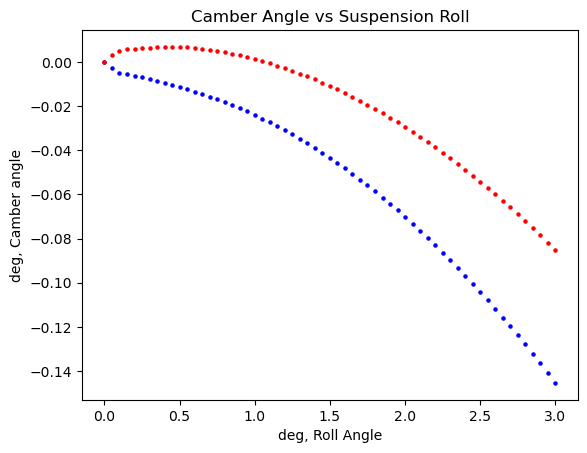

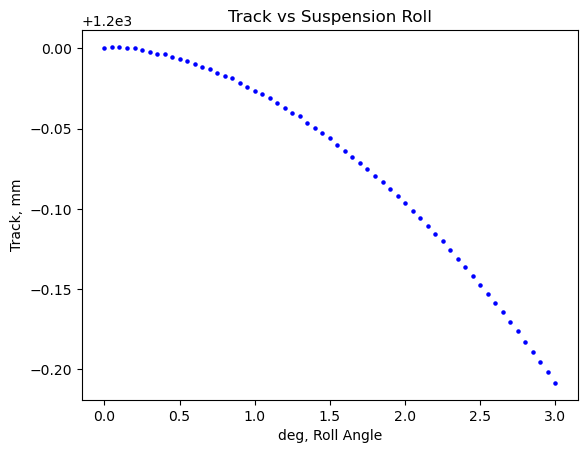

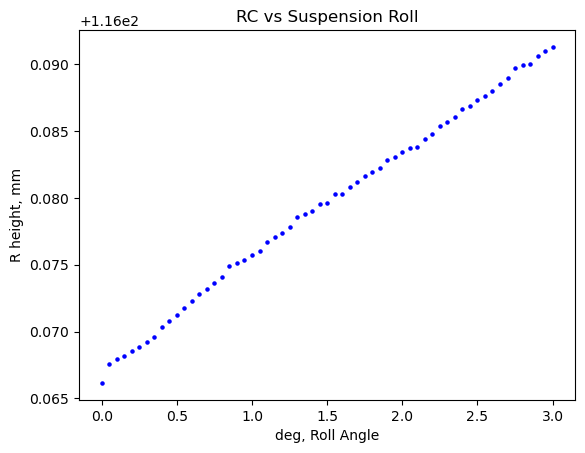

In [4]:
fig, ax = plt.subplots()
for i in range(steps):
    ax.scatter(A[i]*360/(2*pi),-((UprUUOA[i]+To+T90)-pi/2)*360/(2*pi), label="Left Camber", s=5, color='blue')
    #plt.xlabel("deg, Roll Angle")
    #plt.ylabel("deg, Camber angle")
    #ax.set_title("Camber Angle vs Suspension Travel")

#fig, ax = plt.subplots()
#for i in range(steps):
    ax.scatter(A[i]*360/(2*pi),(-(UprUUOB[i]+To+T90)+pi/2)*360/(2*pi), label="Right Camber", s=5, color='red')
plt.xlabel("deg, Roll Angle")
plt.ylabel("deg, Camber angle")
ax.set_title("Camber Angle vs Suspension Roll")
plt.show()

fig, ax = plt.subplots()
for i in range(steps):
    ax.scatter(A[i]*360/(2*pi),Track[i], s=5, color='blue')
plt.xlabel("deg, Roll Angle")
plt.ylabel("Track, mm")
ax.set_title("Track vs Suspension Roll")
plt.show()

fig, ax = plt.subplots()
for i in range(steps):
    ax.scatter(A[i]*360/(2*pi),RCroll[i][1], s=5, color='blue')
plt.xlabel("deg, Roll Angle")
plt.ylabel("R height, mm")
ax.set_title("RC vs Suspension Roll")
plt.show()

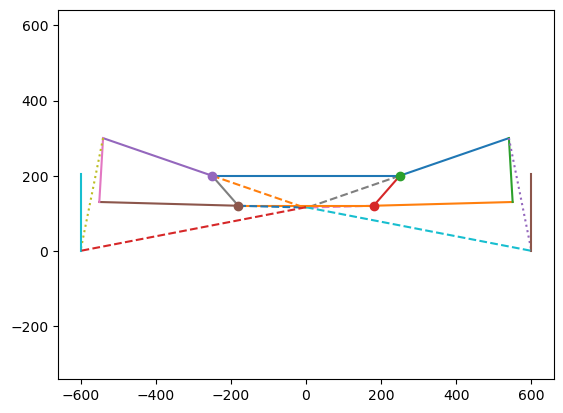

right roll go down UC: [250. 200.] LC: [180. 120.] UU: [540.0, 300.0] LU: [550.0, 130.0] tire bottom [600.0, 0.0] tire top [array([600., 550.]), 203.2]
left roll go up UC: [250. 200.] LC: [180. 120.] UU: [540.0, 300.0] LU: [550.0, 130.0] tire bottom [600.0, 0.0] tire top [600.0, 203.2]


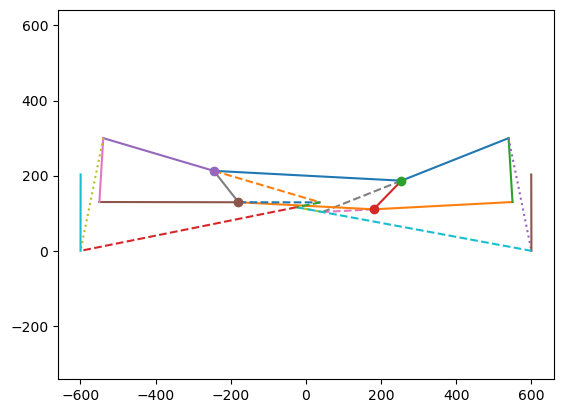

right roll go down UC: [254.01443392 186.68123466] LC: [179.94153956 110.43767031] UU: [539.1346891810873, 299.8467773004683] LU: [549.5660511824916, 129.87270078644323] tire bottom [599.8957798767233, -1.1368683772161603e-13] tire top [array([599.38013693, 532.04693766]), 203.1993457478391]
left roll go up UC: [245.30612829 212.84925038] LC: [179.94153956 110.43767031] UU: [539.4495534701524, 299.9104094779065] LU: [549.7024416575256, 129.92547401650384] tire bottom [599.8957798767233, 0.0] tire top [599.5934908875147, 203.1997751508771]


In [5]:
r=60
for c in range(2):
    r=60*c
    l=r#r and l are inputs #,ICLA[r],ICUA[r],RRCUA[r],-RRCLA[r]]
    i=1
    
    #print(((UprUUOA[r]+To+T90)-pi/2)*360/(2*pi))
    fig, ax = plt.subplots()
    for start, R, O, style in zip([UCA[r],LCA[r],
        [UCA[r][0]+ U*cos(UUCOA[r]),UCA[r][1]+ U*sin(UUCOA[r])],
        LCA[r],
        [UCA[r][0]+ U*cos(UUCOA[r]),UCA[r][1]+ U*sin(UUCOA[r])],
        [UCA[r][0]+ U*cos(UUCOA[r]) +TUU*cos(UprUUOA[r]+To),UCA[r][1]+ U*sin(UUCOA[r])+TUU*sin(UprUUOA[r]+To)],
                                   LCA[r],UCA[r],ICA[r],[ICA[r][0]+RCUA[r]*cos(TROA[r]),ICA[r][1]+RCUA[r]*sin(TROA[r])],
                                  [-UCB[r][0],UCB[r][1]],[-LCB[r][0],LCB[r][1]]],
        
        [U,L,Upr,C,TUU,TD/2,ICLA[r],ICUA[r],RCUA[r],-RCLA[r],Ctop,Cbot],
        [UUCOA[r],LLCOA[r],UprUUOA[r],CLCo-A[r],UprUUOA[r]+To,UprUUOA[r]+To+T90,LLCOA[r]+pi,UUCOA[r]+pi,TROA[r],TROA[r],-A[r],-A[r]],
        ('-' ,'-' ,'-' ,'-' ,':',"-","--","--","--","--","-","-")):
        ax.plot([start[0],start[0]+R*cos(O)],[start[1],start[1]+R*sin(O)], style)
        #print(i)
        if i == 111: break
        i+=1
        
        #ax.plot([-start[0],-start[0]-R*cos(O)],[start[1],start[1]+R*sin(O)], style) #other side
    ax.plot(UCA[r][0],UCA[r][1],"o")
    ax.plot(LCA[r][0],LCA[r][1],"o")
    #ax.plot(IC[r][0],IC[r][1],"o")
    #ax.plot(-(LC[0]-ICL[i]*cos(LLCO[h])),(LC[1]-ICL[h]*sin(LLCO[h])),"o")#other side
    
    for start, R, O, style in zip(
        [UCB[l], LCB[l],
         [UCB[l][0] + U*cos(UUCOB[l]), UCB[l][1] + U*sin(UUCOB[l])],
         LCB[l],
         [UCB[l][0] + U*cos(UUCOB[l]), UCB[l][1] + U*sin(UUCOB[l])],
         [UCB[l][0] + U*cos(UUCOB[l]) + TUU*cos(UprUUOB[l] + To), UCB[l][1] + U*sin(UUCOB[l]) + TUU*sin(UprUUOB[l] + To)],
         LCB[l], UCB[l], ICB[l],
         [ICB[l][0] + RCUB[l]*cos(TROB[l]), ICB[l][1] + RCUB[l]*sin(TROB[l])]
        ],
        [U, L, Upr, C, TUU, TD/2, ICLB[l], ICUB[l], RCUB[l], -RCLB[l]],
        [UUCOB[l], LLCOB[l], UprUUOB[l], CLCo + A[l], UprUUOB[l] + To, UprUUOB[l] + To + T90,
         LLCOB[l] + pi, UUCOB[l] + pi, TROB[l], TROB[l]],
        ('-' ,'-' ,'-' ,'-' ,':', "-", "--", "--", "--", "--")):
                
        ax.plot([-start[0],-start[0]+R*cos(pi-O)],[start[1],start[1]+R*sin(O)], style) #other side
    ax.plot(-UCB[r][0],UCB[r][1],"o")
    ax.plot(-LCB[r][0],LCB[r][1],"o")
    plt.axis('equal')
    plt.show()
    print("right roll go down", "UC:",UCA[r], "LC:",LCA[r], "UU:",[UCA[r][0]+ U*cos(UUCOA[r]),UCA[r][1]+ U*sin(UUCOA[r])], "LU:",
          [UCA[r][0]+ U*cos(UUCOA[r])+ Upr*cos(UprUUOA[r]),UCA[r][1]+ U*sin(UUCOA[r])+Upr*sin(UprUUOA[r])],"tire bottom",
      [UCA[r][0]+ U*cos(UUCOA[r]) +TUU*cos(UprUUOA[r]+To),UCA[r][1]+ U*sin(UUCOA[r])+TUU*sin(UprUUOA[r]+To)], "tire top",
     [UCA[r]+ U*cos(UUCOA[r]) +TUU*cos(UprUUOA[r]+To) + TD/2 * cos(UprUUOA[r]+To+T90),UCA[r][1]+ U*sin(UUCOA[r])+TUU*sin(UprUUOA[r]+To)+ TD/2 * sin(UprUUOA[r]+To+T90)])
    print("left roll go up","UC:",UCB[l], "LC:",LCA[l], "UU:",[UCB[l][0]+ U*cos(UUCOB[l]),UCB[l][1]+ U*sin(UUCOB[l])], "LU:",
          [UCB[l][0]+ U*cos(UUCOB[l])+ Upr*cos(UprUUOB[l]),UCB[l][1]+ U*sin(UUCOB[l])+Upr*sin(UprUUOB[l])], "tire bottom",
      [UCB[l][0]+ U*cos(UUCOB[l]) +TUU*cos(UprUUOB[l]+To),UCB[l][1]+ U*sin(UUCOB[l])+TUU*sin(UprUUOB[l]+To)], "tire top",
     [UCB[l][0]+ U*cos(UUCOB[l]) +TUU*cos(UprUUOB[l]+To) + TD/2 * cos(UprUUOB[l]+To+T90),UCB[l][1]+ U*sin(UUCOB[l])+TUU*sin(UprUUOB[l]+To)+ TD/2 * sin(UprUUOB[l]+To+T90)])

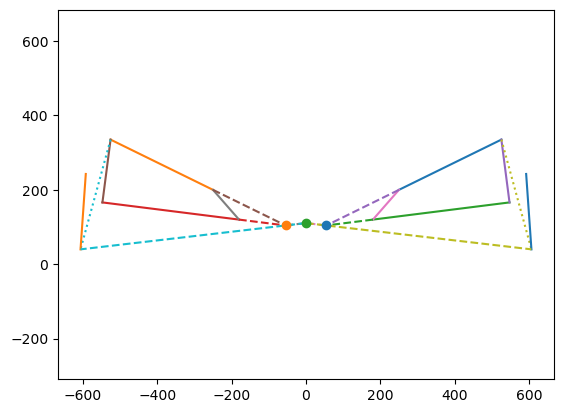

heave high UC: [250, 200] LC: [180, 120] UU: [545.6458507303134, 281.8140021386881] LU: [550.0392547388647, 111.57682053250184] tire bottom [595.7288629512026, -19.999999999851298] tire top [602.4239045012845, 183.089675805303]
heave low UC: [250, 200] LC: [180, 120] UU: [525.4118338342763, 335.0863493623281] LU: [547.2408003384786, 166.1973437362708] tire bottom [606.183403217878, 40.00000000114534] tire top [592.0152184079119, 242.705457597113]


In [6]:
#choose an i in stepsize to see what car is doing in heave
h=60

#49 isneutral (heave)

fig, ax = plt.subplots()
for start, R, O, style in zip([UC,LC,
                        [UC[0]+ U*cos(UUCO[h]),UC[1]+ U*sin(UUCO[h])],
                        LC,
                        [UC[0]+ U*cos(UUCO[h]),UC[1]+ U*sin(UUCO[h])],
                        [UC[0]+ U*cos(UUCO[h]) +TUU*cos(UprUUO[h]+To),UC[1]+ U*sin(UUCO[h])+TUU*sin(UprUUO[h]+To)],LC,UC,IC[h],RC[h][h]],
                              
                        [U,L,Upr,C,TUU,TD/2,ICL[h],ICU[h],RRCU[h][h],-RRCL[h][h]],
                        [UUCO[h],LLCO[h],UprUUO[h],CLCo,UprUUO[h]+To,UprUUO[h]+To+T90,LLCO[h]+pi,UUCO[h]+pi,TRo[h],TRo[h]],
                        ('-' ,'-' ,'-' ,'-' ,':',"-","--","--","--","--")):
        ax.plot([start[0],start[0]+R*cos(O)],[start[1],start[1]+R*sin(O)], style)    
        ax.plot([-start[0],-start[0]-R*cos(O)],[start[1],start[1]+R*sin(O)], style) #other side
ax.plot(IC[h][0],IC[h][1],"o")
ax.plot(-IC[h][0],IC[h][1],"o")#other side
ax.plot(RC[h][h][0],RC[h][h][1],"o")
plt.axis('equal')
plt.show()
print("heave high", "UC:",UC, "LC:",LC, "UU:",[UC[0]+ U*cos(UUCO[0]),UC[1]+ U*sin(UUCO[0])], "LU:",
          [UC[0]+ U*cos(UUCO[0])+ Upr*cos(UprUUO[0]),UC[1]+ U*sin(UUCO[0])+Upr*sin(UprUUO[0])], "tire bottom",
      [UC[0]+ U*cos(UUCO[0]) +TUU*cos(UprUUO[0]+To),UC[1]+ U*sin(UUCO[0])+TUU*sin(UprUUO[0]+To)], "tire top",
     [UC[0]+ U*cos(UUCO[0]) +TUU*cos(UprUUO[0]+To) + TD/2 * cos(UprUUO[0]+To+T90),UC[1]+ U*sin(UUCO[0])+TUU*sin(UprUUO[0]+To)+ TD/2 * sin(UprUUO[0]+To+T90)])
print("heave low", "UC:",UC, "LC:",LC, "UU:",[UC[0]+ U*cos(UUCO[h]),UC[1]+ U*sin(UUCO[h])], "LU:",
          [UC[0]+ U*cos(UUCO[h])+ Upr*cos(UprUUO[h]),UC[1]+ U*sin(UUCO[h])+Upr*sin(UprUUO[h])], "tire bottom",
      [UC[0]+ U*cos(UUCO[h]) +TUU*cos(UprUUO[h]+To),UC[1]+ U*sin(UUCO[h])+TUU*sin(UprUUO[h]+To)], "tire top",
     [UC[0]+ U*cos(UUCO[h]) +TUU*cos(UprUUO[h]+To) + TD/2 * cos(UprUUO[h]+To+T90),UC[1]+ U*sin(UUCO[h])+TUU*sin(UprUUO[h]+To)+ TD/2 * sin(UprUUO[h]+To+T90)])

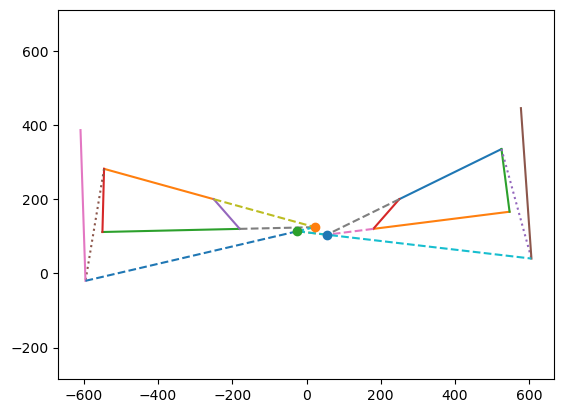

In [7]:

r=60  #r and l are inputs
l=0
fig, ax = plt.subplots()
for start, R, O, style in zip([UC,LC,
                        [UC[0]+ U*cos(UUCO[r]),UC[1]+ U*sin(UUCO[r])],
                        LC,
                        [UC[0]+ U*cos(UUCO[r]),UC[1]+ U*sin(UUCO[r])],
                        [UC[0]+ U*cos(UUCO[r]) +TUU*cos(UprUUO[r]+To),UC[1]+ U*sin(UUCO[r])+TUU*sin(UprUUO[r]+To)],LC,UC,IC[r],RC[r][l]],
                              
                        [U,L,Upr,C,TUU,TD,ICL[r],ICU[r],RRCU[r][l],-RRCL[r][l]],
                        [UUCO[r],LLCO[r],UprUUO[r],CLCo,UprUUO[r]+To,UprUUO[r]+To+T90,LLCO[r]+pi,UUCO[r]+pi,TRo[r],TRo[r]],
                        ('-' ,'-' ,'-' ,'-' ,':',"-","--","--","--","--")):
        ax.plot([start[0],start[0]+R*cos(O)],[start[1],start[1]+R*sin(O)], style)    
        #ax.plot([-start[0],-start[0]-R*cos(O)],[start[1],start[1]+R*sin(O)], style) #other side
ax.plot(IC[r][0],IC[r][1],"o")
#ax.plot(-(LC[0]-ICL[i]*cos(LLCO[h])),(LC[1]-ICL[h]*sin(LLCO[h])),"o")#other side

for start, R, O, style in zip([UC,LC,
                        [UC[0]+ U*cos(UUCO[l]),UC[1]+ U*sin(UUCO[l])],
                        LC,
                        [UC[0]+ U*cos(UUCO[l]),UC[1]+ U*sin(UUCO[l])],
                        [UC[0]+ U*cos(UUCO[l]) +TUU*cos(UprUUO[l]+To),UC[1]+ U*sin(UUCO[l])+TUU*sin(UprUUO[l]+To)],LC,UC,IC[l],[-RC[r][l][0],RC[r][l][1]]],
                              
                        [U,L,Upr,C,TUU,TD,ICL[l],ICU[l],-LRCU[r][l],+LRCL[r][l]],
                        [UUCO[l],LLCO[l],UprUUO[l],CLCo,UprUUO[l]+To,UprUUO[l]+To+T90,LLCO[l]+pi,UUCO[l]+pi,TRo[l],TRo[l]],
                        ('-' ,'-' ,'-' ,'-' ,':',"-","--","--","--","--")):
            
        ax.plot([-start[0],-start[0]-R*cos(O)],[start[1],start[1]+R*sin(O)], style) #other side
ax.plot(-IC[l][0],IC[l][1],"o")
ax.plot(RC[r][l][0],RC[r][l][1],"o")
plt.axis('equal')
plt.show()

-0.09626028495050111


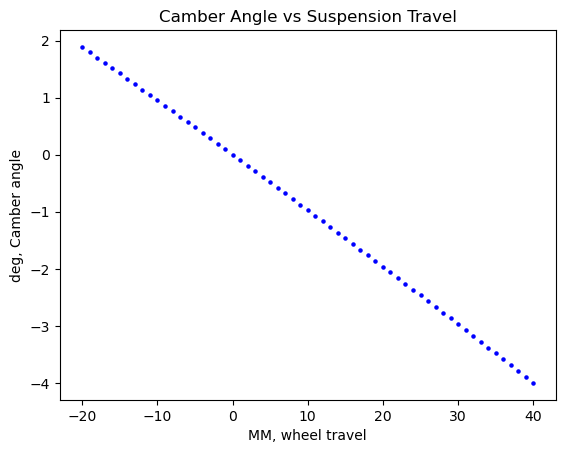

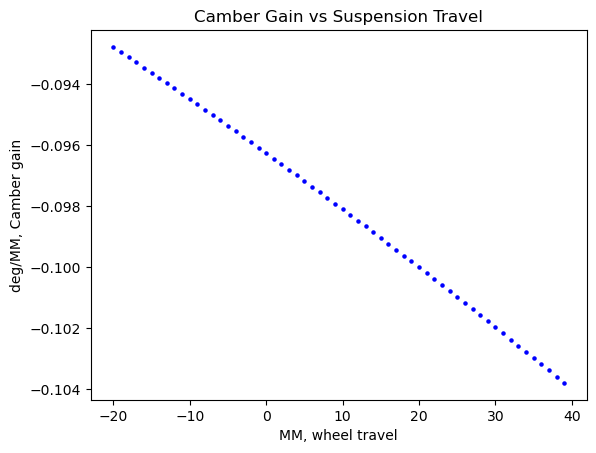

In [8]:

#graph camber gain
fig, ax = plt.subplots()
for i in range(steps):
    ax.scatter(MM[i],(-(UprUUO[i]+To+T90)+pi/2)*360/(2*pi), s=5, color='blue')
    plt.xlabel("MM, wheel travel")
    plt.ylabel("deg, Camber angle")
    ax.set_title("Camber Angle vs Suspension Travel")
fig, ax = plt.subplots()
for i in range(steps-1):
    ax.scatter(MM[i],(-((UprUUO[i+1])-(UprUUO[i])))*360/(2*pi)/(stepsize),s=5, color='blue')
    plt.xlabel("MM, wheel travel")
    plt.ylabel("deg/MM, Camber gain")
    ax.set_title("Camber Gain vs Suspension Travel")
    if MM[i]>-.1 and MM[i]<.1:
        print((-((UprUUO[i+1])-(UprUUO[i])))*360/(2*pi)/(stepsize))
'''
fig, ax = plt.subplots()
for i in range(steps):
    ax.scatter(MM[i],ICL[i], s=5, color='blue')
    plt.xlabel("MM, wheel travel")
    plt.ylabel("ICL length")
    ax.set_title("Instant Center vs Suspension Travel")
fig, ax = plt.subplots()
for i in range(steps):
    ax.scatter(MM[i],ICU[i], s=5, color='blue')
    plt.xlabel("MM, wheel travel")
    plt.ylabel("ICU length")
    ax.set_title("Instant Centervs Suspension Travel")
#((-((UprUUO[i+1])-(UprUUO[i])))*360/(2*pi)/(stepsize))
#
fig, ax = plt.subplots()
for i in range(steps-1):
    ax.scatter((ICU[i]+ICL[i]+U+L)/2,((-((UprUUO[i+1])-(UprUUO[i])))*360/(2*pi)/(stepsize)), s=5, color='blue')
    plt.ylabel("deg/MM, Camber Gain")
    plt.xlabel("IC avg length")
    ax.set_title("Instant Center average vs Suspension Travel")
fig, ax = plt.subplots()
for i in range(steps-1):
    ax.scatter(MM[i],((-((UprUUO[i+1])-(UprUUO[i])))*360/(2*pi)/(stepsize))/((ICU[i]+ICL[i]+U+L)/2), s=5, color='blue')
    plt.xlabel("MM, wheel travel")
    plt.ylabel("deg/MM, Camber Gain/IC avg length")
    ax.set_title("Instant Center average vs Suspension Travel")
    '''
plt.show()
 


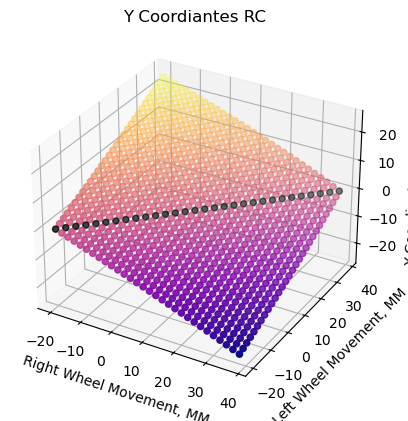

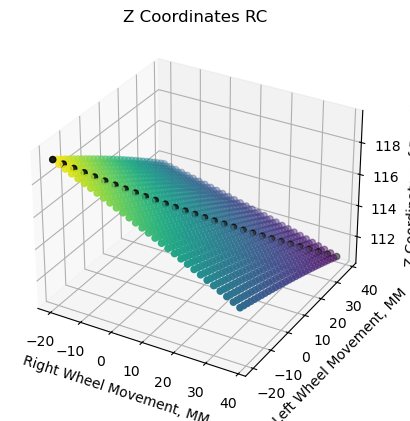

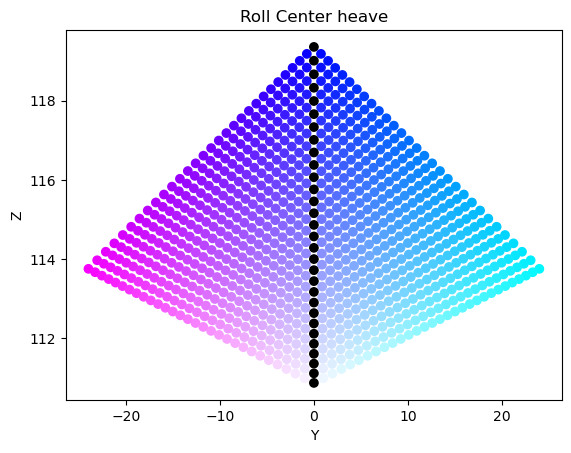

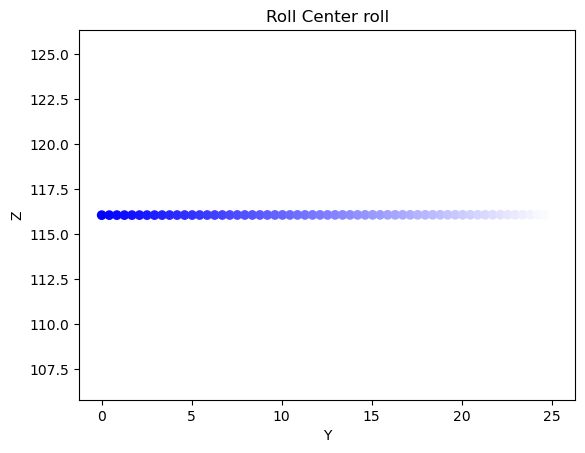

In [9]:
from mpl_toolkits import mplot3d
#%matplotlib qt
import matplotlib.pyplot as plt

steps10=int((steps-1)/2)
fig = plt.figure()
# syntax for 3-D projectin
R3D=[]
L3D=[]
Y3D=[]
Z3D=[]
RRY=[]
RRZ=[]
Color_vals = []

Color_vals_r = []
for r in range(steps10):
    for l in range(steps10):
        R3D.append(MM[r*2])
        L3D.append(MM[l*2])
        Y3D.append(RC[r*2][l*2][0])
        Z3D.append(RC[r*2][l*2][1])
        if l==r:
            Color_vals.append([0,0,0])
        else:
            Color_vals.append([2*r/(steps-1),2*l/(steps-1),1])
Color_vals_r = []
for i in range(steps):
    RRY.append(RCroll[i][0])
    RRZ.append(RCroll[i][1])
    Color_vals_r.append([i/(steps-1),i/(steps-1),1])

colors = np.array(Y3D)
cmap = plt.cm.plasma
norm = plt.Normalize(vmin=np.min(colors), vmax=np.max(colors))
mapped_colors = cmap(norm(colors))
for i in range(len(R3D)):
    if np.isclose(R3D[i], L3D[i], atol=1e-6):  # You can adjust tolerance
        mapped_colors[i] = (0, 0, 0, 1)

ax = plt.axes(projection ='3d')
ax.scatter(R3D,L3D,Y3D,c=mapped_colors)
ax.set_title('Y Coordiantes RC')
ax.set_xlabel("Right Wheel Movement, MM")
ax.set_ylabel("Left Wheel Movement, MM")
ax.set_zlabel("Y Coordinates of RC, MM")
plt.show()



colors = np.array(Z3D)
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=np.min(colors), vmax=np.max(colors))
mapped_colors = cmap(norm(colors))
for i in range(len(R3D)):
    if np.isclose(R3D[i], L3D[i], atol=1e-6):  # You can adjust tolerance
        mapped_colors[i] = (0, 0, 0, 1)


fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(R3D,L3D,Z3D,c=mapped_colors)
ax.set_title('Z Coordinates RC')
ax.set_xlabel("Right Wheel Movement, MM")
ax.set_ylabel("Left Wheel Movement, MM")
ax.set_zlabel("Z Coordinates of RC, MM")
plt.show()

fig, ax = plt.subplots()
ax.scatter(Y3D,Z3D, c=Color_vals)
plt.xlabel("Y")
plt.ylabel("Z")
ax.set_title("Roll Center heave")  
#plt.axis('equal')
plt.show()

fig, ax = plt.subplots()
ax.scatter(RRY,RRZ, c=Color_vals_r)
plt.xlabel("Y")
plt.ylabel("Z")
ax.set_title("Roll Center roll")  
plt.axis('equal')
plt.show()
 